X-ray Transform Comparison
==========================

This example compares SCICO's native X-ray transform algorithm
to that of the ASTRA toolbox.

In [1]:
import numpy as np

import jax
import jax.numpy as jnp

from xdesign import Foam, discrete_phantom

import scico.linop.xray.astra as astra
from scico import plot
from scico.linop import Parallel2dProjector, XRayTransform
from scico.util import Timer
plot.config_notebook_plotting()

I0000 00:00:1698343857.973988  451581 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Create a ground truth image.

In [2]:
N = 512

det_count = int(jnp.ceil(jnp.sqrt(2 * N**2)))

x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)

Time projector instantiation.

In [3]:
num_angles = 500
angles = jnp.linspace(0, jnp.pi, num=num_angles, endpoint=False)


timer = Timer()

projectors = {}
timer.start("scico_init")
projectors["scico"] = XRayTransform(Parallel2dProjector((N, N), angles))
timer.stop("scico_init")

timer.start("astra_init")
projectors["astra"] = astra.XRayTransform(
    (N, N), detector_spacing=1.0, det_count=det_count, angles=angles - jnp.pi / 2.0
)
timer.stop("astra_init")

Time first projector application, which might include JIT overhead.

In [4]:
ys = {}
for name, H in projectors.items():
    timer_label = f"{name}_first_fwd"
    timer.start(timer_label)
    ys[name] = H @ x_gt
    jax.block_until_ready(ys[name])
    timer.stop(timer_label)

Compute average time for a projector application.

In [5]:
num_repeats = 3
for name, H in projectors.items():
    timer_label = f"{name}_avg_fwd"
    timer.start(timer_label)
    for _ in range(num_repeats):
        ys[name] = H @ x_gt
        jax.block_until_ready(ys[name])
    timer.stop(timer_label)
    timer.td[timer_label] /= num_repeats

Time first back projection, which might include JIT overhead.

In [6]:
y = np.zeros(H.output_shape, dtype=np.float32)
y[num_angles // 3, det_count // 2] = 1.0
y = jax.device_put(y)

HTys = {}
for name, H in projectors.items():
    timer_label = f"{name}_first_back"
    timer.start(timer_label)
    HTys[name] = H.T @ y
    jax.block_until_ready(ys[name])
    timer.stop(timer_label)

Compute average time for back projection.

In [7]:
num_repeats = 3
for name, H in projectors.items():
    timer_label = f"{name}_avg_back"
    timer.start(timer_label)
    for _ in range(num_repeats):
        HTys[name] = H.T @ y
        jax.block_until_ready(ys[name])
    timer.stop(timer_label)
    timer.td[timer_label] /= num_repeats

Display timing results.

On our server, the SCICO projection is more than twice as fast as ASTRA
when both are run on the GPU, and about 10% slower when both are run the
CPU. The SCICO back projection is slow the first time it is run, probably
due to JIT overhead. After the first run, it is an order of magnitude
faster than ASTRA when both are run on the GPU, and about three times
faster when both are run on the CPU.

On our server, using the GPU:
```
init         astra    1.36e-03 s
init         scico    1.37e+01 s

first  fwd   astra    6.92e-02 s
first  fwd   scico    2.95e-02 s

first  back  astra    4.20e-02 s
first  back  scico    7.63e+00 s

avg    fwd   astra    4.62e-02 s
avg    fwd   scico    1.61e-02 s

avg    back  astra    3.71e-02 s
avg    back  scico    1.05e-03 s
```

Using the CPU:
```
init         astra    1.06e-03 s
init         scico    1.00e+01 s

first  fwd   astra    9.16e-01 s
first  fwd   scico    1.04e+00 s

first  back  astra    9.39e-01 s
first  back  scico    1.00e+01 s

avg    fwd   astra    9.11e-01 s
avg    fwd   scico    1.03e+00 s

avg    back  astra    9.34e-01 s
avg    back  scico    2.62e-01 s
```

In [8]:
print(f"init         astra    {timer.td['astra_init']:.2e} s")
print(f"init         scico    {timer.td['scico_init']:.2e} s")
print("")
for tstr in ("first", "avg"):
    for dstr in ("fwd", "back"):
        for pstr in ("astra", "scico"):
            print(
                f"{tstr:5s}  {dstr:4s}  {pstr}    {timer.td[pstr + '_' + tstr + '_' + dstr]:.2e} s"
            )
        print()

init         astra    1.47e-02 s
init         scico    8.74e+00 s

first  fwd   astra    9.41e-01 s
first  fwd   scico    9.96e-01 s

first  back  astra    9.34e-01 s
first  back  scico    8.15e+00 s

avg    fwd   astra    9.14e-01 s
avg    fwd   scico    9.87e-01 s

avg    back  astra    9.33e-01 s
avg    back  scico    2.96e-01 s



Show projections.

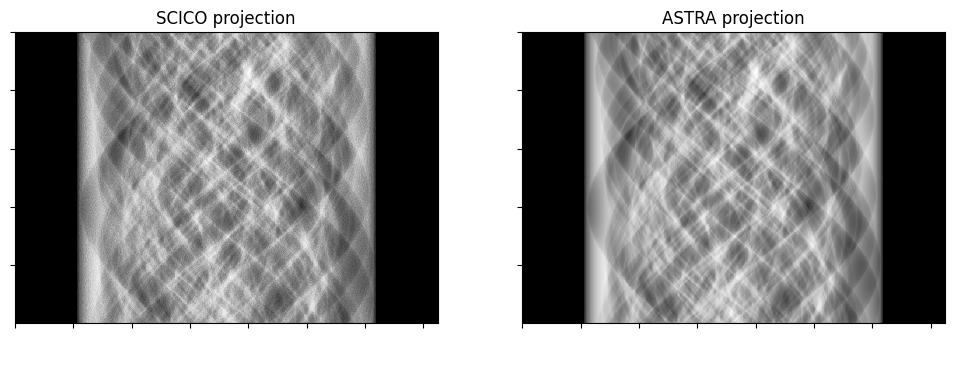

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))
plot.imview(ys["scico"], title="SCICO projection", cbar=None, fig=fig, ax=ax[0])
plot.imview(ys["astra"], title="ASTRA projection", cbar=None, fig=fig, ax=ax[1])
fig.show()

Show back projections of a single detector element, i.e., a line.

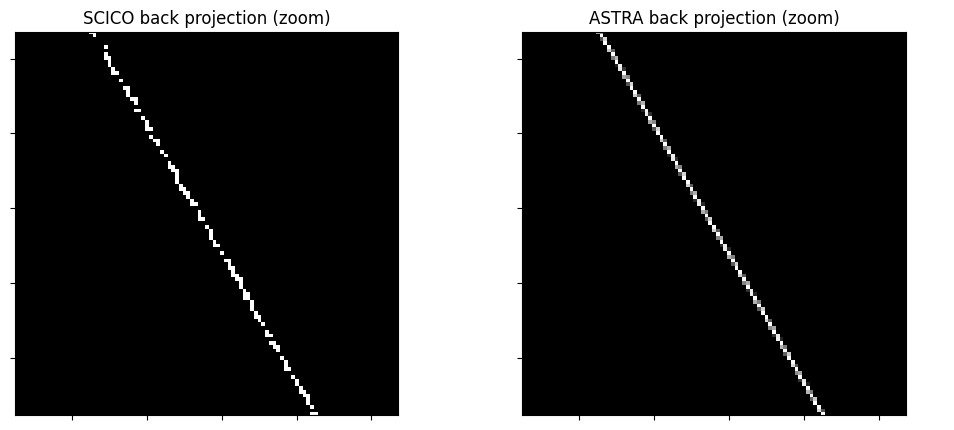

In [10]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))
plot.imview(HTys["scico"], title="SCICO back projection (zoom)", cbar=None, fig=fig, ax=ax[0])
plot.imview(HTys["astra"], title="ASTRA back projection (zoom)", cbar=None, fig=fig, ax=ax[1])
for ax_i in ax:
    ax_i.set_xlim(2 * N / 5, N - 2 * N / 5)
    ax_i.set_ylim(2 * N / 5, N - 2 * N / 5)
fig.show()